# Document loading

In [1]:
import numpy as np # Used for images .
import pymupdf # For pdf loading
from pathlib import Path # For Loading the directory or PDF path .
from typing import List,Dict
import traceback # Used for error handling .

In [2]:
# The following function is used to check if the image has detailing since if there is no much variance(Basically flat image) it removes it .
# threshold -> minimum variance value .
def is_low_variance(pix, threshold: int = 5) -> bool:
    samples = np.frombuffer(pix.samples, dtype=np.uint8) # Storing pixels (raw bytes) into numpy array .

    if pix.n >= 3:
        samples = samples.reshape(-1, pix.n)[:, :3].mean(axis=1) # Converting to grayscale

    return samples.std() < threshold # Returns false if standard variance is less than threshold .

In [3]:
# The following function checks if image is mostly white .
# threshold -> 245 -> white
# ratio -> The threshold color present in the whole picture .
def is_mostly_white(pix, threshold=245, ratio=0.98) -> bool:
    samples = np.frombuffer(pix.samples, dtype=np.uint8) # Storing pixels (raw bytes) into numpy array .

    if pix.n >= 3:
        samples = samples.reshape(-1, pix.n)[:, :3].mean(axis=1)
    white_pixels = np.sum(samples > threshold) # Number of nearby white color variants in image .

    return (white_pixels / len(samples)) > ratio # Returns false if most of the pixels are white (Less than threshold) .

In [4]:
# Function to load all the PDF's from Directory .
def loading_pdf(dir_path:str='../data/pdf')->List[Dict]: # Return type .
    dir_path=Path(dir_path) # Loading directory Path

    if not dir_path.is_dir(): # Checking if the directory is valid .
        raise NotADirectoryError(f"{dir_path} is a invalid directory .")

    print(f"The directory path is : {dir_path} .")
    pdf_files=list(dir_path.rglob("*.pdf")) # Storing all the PDF's path into list .
    print(f"Number of PDF's in directory is {len(pdf_files)}")

    if len(pdf_files)==0: # Checking if any PDFs exists in the directory .
        print('No documents in the dir_path')
        return []

    # All these variables used for stats check at the end .
    all_pdf_size=0.0
    all_pages=[]
    failed_pdf=[]

    print("="*20,"PDF LOAD SUMMARY","="*20)
    print("-"*45)

    for serial,pdf_path in enumerate(pdf_files,start=1): # Iterating through all the PDFs in directory .
        print(f"{serial} ---> Loading {pdf_path.name} ")
        pdf_size_bytes=pdf_path.stat().st_size
        pdf_size_mb=pdf_size_bytes/(1024**2) # Calculating size of the PDF .
        print(f"File size : {pdf_size_mb:.3f} MB")
        try:
            imag_dir= Path('../data/images_pymupdf') / pdf_path.stem # Directory for storing images in the PDF .
            imag_dir.mkdir(parents=True,exist_ok=True)
            pdf=pymupdf.open(filename=pdf_path,filetype="pdf") # Loading PDF .

            for page_num,page in enumerate(pdf,start=1):
                text_blocks=[] # Used for storing details about block of a page .
                page_images=[] # Used for storing images of current page .
                seen_xrefs=set()
                for img_index,img in enumerate(page.get_images(full=True)): # Extracting images .

                    if img[1]!=0: # Removing soft mask . soft mask -> Transparency layer
                        continue
                    xref=img[0]
                    if xref in seen_xrefs: # Checking if the same images are being stored
                        continue

                    seen_xrefs.add(xref)
                    rects=page.get_image_rects(xref) # Used for getting image edges .

                    if not rects: # Checking if coordinates or image is empty .
                        continue

                    pix=pymupdf.Pixmap(pdf,xref) # xref is used to find position if image in PDF .

                    if pix.width<50 or pix.height<50: # Removing very tiny images .
                        pix=None
                        continue

                    if pix.alpha and pix.samples is not None: # Removing fully transparent images .
                        if max(pix.samples)==0:
                            continue

                    if pix.n>4: # If image is CMY color format converting it into RGB .
                        pix=pymupdf.Pixmap(pymupdf.csRGB,pix)

                    if is_mostly_white(pix): # Checking if the image is mostly white .
                        pix=None
                        continue

                    if is_low_variance(pix): # Checking if its a flat image .
                        pix=None
                        continue

                    img_path=imag_dir/f"page_{page_num}_img_{img_index}.png" # Location for storing images in local disk .
                    pix.save(img_path) # Saving images in local disk .
                    pix=None

                    rect=rects[0] # Changed the method since we needed only approx coordinates and not all approx coordinates to be merged , using a FOR loop made multiple copy of image .
                    page_images.append({
                        "image_id":f"{pdf_path.stem}_p{page_num}_i{img_index}",
                        "path":str(img_path),
                        "page":page_num,
                        "bbox":[rect.x0,rect.y0,rect.x1,rect.y1]
                    }) # For metadata .

                # Following loop is to extract texts from a page .
                blocks=sorted(page.get_text("blocks"),key=lambda b:(b[1],b[0]))
                for block_id,b in enumerate(blocks):
                    x0,y0,x1,y1,text=b[:5] # Coordinates and text of text block .
                    text=text.strip()
                    if len(text) < 20: # If texts are smaller it is removed since smaller texts can not be very useful .
                        continue
                    block_bbox=[x0,y0,x1,y1] # Coordinates of the textblocks . Used while checking relevance of image and text .

                    text_blocks.append({
                        "block_id":block_id,
                        "text":text,
                        "bbox":block_bbox,
                        "page":page_num,
                    }) # Used while appending metadata .

                all_pages.append({
                    "source":pdf_path.name,
                    "page":page_num,
                    "text_blocks":text_blocks,
                    "images":page_images
                })
            all_pdf_size+=pdf_size_mb
            pdf.close()
            print("-"*45)
        except Exception as e:
            print(f" Error loading {pdf_path.name} . Error {e}") # Exception handling .
            failed_pdf.append(pdf_path.name) # Storing the PDF failed to load .
            traceback.print_exc() # Used to trace failures similar to python interpreter stack trace .

    # Some stats of Loading all the PDF in a directory .
    print(f"Total size of all the PDF's are : {all_pdf_size:.3f} MB")
    print(f"Total Number of pages extracted : {len(all_pages)} ")
    print("-"*45)

    # Printing all the PDF which where not able to load .
    if failed_pdf:
        print(f"Failed PDF : {failed_pdf}")

    return all_pages # Returning the loaded pages .

# Chunking

In [5]:
from langchain_core.documents import Document # Datatype of a block or a chunk .
from typing import List # Used to store list of Documents or to specify return type .

In [6]:
# The following function is to calculate distance between two blocks and a threshold is set such that if two blocks are far those both blocks are separated with different chunks .
def vertical_gap(block1,block2)->float:
    return block2["bbox"][1]-block1["bbox"][3] # Distance between bottom of block 1 and top of block 2.

In [7]:
# The following function is used for getting outermost edge of all the chunks combined .
def merge_bbox(blocks):
    if not blocks:
        return None
    return(
        min(b["bbox"][0] for b in blocks), # x0 left
        min(b["bbox"][1] for b in blocks), # y0 top
        max(b["bbox"][2] for b in blocks), # x1 right
        max(b["bbox"][3] for b in blocks)  # y1 bottom1
    )

In [8]:
# The following function is used create a chunk by adding
def build_chunk(source:str,page_num:int,blocks:List)->Document:

    if not blocks:
        return None

    chunk_text="\n".join(b["text"] for b in blocks) # Combing all the texts from the blocks .
    chunk_bbox=merge_bbox(blocks) # Used to get overall chunk coordinates .

    return Document(
        page_content=chunk_text,
        metadata={
            "source":source,
            "page_num":page_num,
            "bbox":chunk_bbox,
            "chunk_id":f"{source}_p{page_num}_c{hash(chunk_text) % 10**8}"
        }
    ) # Adding metadata .

In [9]:
# The following function is used to check if a block is relevant to another block using coordinates .
def bbox_overlap(a,b)->bool:
    return not(
        a[2] < b[0] or # right edge of a and left edge of b (here we are considering a is at left and b is right side of a .)
        a[0] > b[2] or # left edge of a and right edge of b (here we are considering b is at left and a is right side of b .)
        a[3] < b[1] or # bottom edge of a and top edge of b (here we are considering a is at top and b is below of a .)
        a[1] > b[3]    # top edge of a and bottom edge of b (here we are considering b is at top and a is below of b .)
    )

In [10]:
# The following function helps to identify if the text block near the image is caption of the image based on the coordinates and length of the text .
def is_caption_block(text_block:Dict,image:Dict,max_words:int=60,max_vertical_dist:int=80)->bool:

    text=text_block['text'] # Text

    if len(text.split()) > max_words: # Checking if the text is large .
        return False

    tb_x0,tb_y0,tb_x1,tb_y1=text_block["bbox"] # Coordinates of text block .
    im_x0,im_y0,im_x1,im_y1=image["bbox"] # Coordinates of image .

    horizontal_overlap=not(tb_x1 < im_x0 or tb_x0 > im_x1) # Checking for a overlap .

    vertical_distance=min( # Vertical distance between text block and image .
        abs(tb_y0 - im_y1),
        abs(im_y0 - tb_y1)
    )
    return horizontal_overlap and vertical_distance <= max_vertical_dist # Returns false if nay condition fails .

In [11]:
# Build image objects , mainly used for embedding using openclip and also can be used parallely with text block in graph db .
def build_image_objects(pages:List[Dict])->List[Dict]:

    image_objects=[]

    # Getting text block and images from the page .(For reference this are the pages already loaded from pdf_loading .)
    for page in pages:
        source=page["source"]
        page_num=page["page"]
        text_blocks=page.get("text_blocks",[])
        images=page.get("images",[])

        # For every text block in page checking if the image is relevant or caption to it .
        for img in images:
            caption_blocks=[
                tb["text"] for tb in text_blocks
                if is_caption_block(tb,img)
            ]


            caption_text=" ".join(caption_blocks).strip() or None # Caption gathered from text blocks .

            # Appending image objects .
            image_objects.append({
                "image_id":img["image_id"],
                "source":source,
                "page":page_num,
                "bbox":img["bbox"],
                "path":img["path"],
                "caption_text":caption_text
            })

    return image_objects # List of image objects with relevant metadata .

## Main chunking strategy

In [12]:
# The following function is main chunking strategy , it uses bbox , max characters to chunk different blocks together .
# max_chars -> maximum characters in a single chunk . (I guess we can replace with token based chunking using tiktoken need to check on that .)
# max_vertical_gap -> maximum vertical height between two blocks . Calculated using bbox .

def bbox_chunker(pages:List[Dict],max_chars:int=1000,max_vertical_gap:int=40)->List[Document]:
    all_chunks=[] # Used to store chunks .

    # Extracting data from a dictionary .
    for page in pages:
        source=page["source"]
        page_num=page["page"]
        blocks=page.get("text_blocks",[])

        if not blocks:
            continue

        current_blocks=[] # Used to store blocks to store in a chunk .
        current_len=0 # Calculating maximum characters in chunk .

        for block in blocks:
            text=block["text"]
            block_len=len(text) # Calculating characters in a single block .

            if current_blocks:
                gap=vertical_gap(current_blocks[-1],block) # Previous block and current block
            else:
                gap=0 # Basically first block of a page .

            if current_len + block_len > max_chars or gap > max_vertical_gap: # Checking conditions for creating a chunk .(Basically threshold that chunk should have certain number of characters and text block distances .)
                chunk=build_chunk(source,page_num,current_blocks)
                if chunk:
                    all_chunks.append(chunk)# Creating a chunk and appending it .
                current_blocks=[]
                current_len=0
            current_blocks.append(block)
            current_len+=block_len

        if current_blocks: # Checking if any text blocks remains from a page .
            chunk=build_chunk(source,page_num,current_blocks)
            if chunk:
                all_chunks.append(chunk) # If any block is missed at end of a page then it is chunked separately .

    print(f"{len(all_chunks)} of chunks were created from {len(pages)} pages .")
    return all_chunks

In [13]:
pages=loading_pdf() # Loading PDF

The directory path is : ..\data\pdf .
Number of PDF's in directory is 1
==================== PDF LOAD SUMMARY ====================
---------------------------------------------
1 ---> Loading hubble-science-highlights.pdf 
File size : 14.789 MB
---------------------------------------------
Total size of all the PDF's are : 14.789 MB
Total Number of pages extracted : 78 
---------------------------------------------


In [14]:
chunks=bbox_chunker(pages) # Creating chunks .

161 of chunks were created from 78 pages .


In [15]:
print(chunks[1]) # Displaying a single chunk .

page_content='HUBBLE SPACE TELESCOPE' metadata={'source': 'hubble-science-highlights.pdf', 'page_num': 2, 'bbox': (443.36920166015625, 366.5845947265625, 565.1551513671875, 379.16461181640625), 'chunk_id': 'hubble-science-highlights.pdf_p2_c85493813'}


In [16]:
print(chunks[1].page_content) # Page content of a chunk .

HUBBLE SPACE TELESCOPE


In [17]:
print(chunks[1].metadata) # Metadata of a chunk .

{'source': 'hubble-science-highlights.pdf', 'page_num': 2, 'bbox': (443.36920166015625, 366.5845947265625, 565.1551513671875, 379.16461181640625), 'chunk_id': 'hubble-science-highlights.pdf_p2_c85493813'}


In [18]:
image_objects=build_image_objects(pages) # Image objects .

In [19]:
print(image_objects[1]) # Displaying details of a image object .

{'image_id': 'hubble-science-highlights_p2_i0', 'source': 'hubble-science-highlights.pdf', 'page': 2, 'bbox': [39.327880859375, 25.74951171875, 581.6133422851562, 364.67791748046875], 'path': '..\\data\\images_pymupdf\\hubble-science-highlights\\page_2_img_0.png', 'caption_text': 'HUBBLE SPACE TELESCOPE'}


In [20]:
print("Total number of image objects :",len(image_objects)) # Total number of image objects from all the pages .

Total number of image objects : 130


In [21]:
caption_num=0
for img in image_objects:
    if img["caption_text"]:
        caption_num+=1
print("Total number of captions available :",caption_num) # Total number of captions extracted .

Total number of captions available : 70


In [22]:
import matplotlib.pyplot as plt

In [23]:
img_path=image_objects[21].get("path") # Fetching details of image from a image object .
caption=image_objects[21].get("caption_text")
img=plt.imread(img_path)

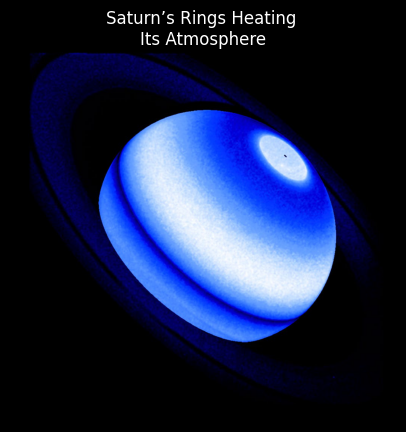

In [24]:
plt.imshow(img) # Displaying image with a caption
plt.axis("off")
plt.title(caption)
plt.show()